In [ ]:
import tweepy
import pandas as pd
import config as cf

In [2]:
auth = tweepy.OAuthHandler(cf.consumer_key, cf.consumer_secret)
auth.set_access_token(cf.access_token, cf.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


In [3]:
user_data = api.get_user(screen_name = 'tiivik')

1150031605819465728

In [4]:
user_list = ["1150031605819465728"]
follower_list = []
for user in user_list:
    followers = []
    try:
        for page in tweepy.Cursor(api.get_follower_ids, user_id=user).pages():
            followers.extend(page)
            print(len(followers))
    except tweepy.errors.TweepyException:
        print("error")
        continue
    follower_list.append(followers)

1093


In [5]:
df = pd.DataFrame(columns=['source','target']) #Empty DataFrame
df['target'] = follower_list[0] #Set the list of followers as the target column
df['source'] = 1150031605819465728 #Set my user ID as the source 

In [6]:
import networkx as nx
G = nx.from_pandas_edgelist(df, 'source', 'target') #Turn df into graph
pos = nx.spring_layout(G) #specify layout for visual

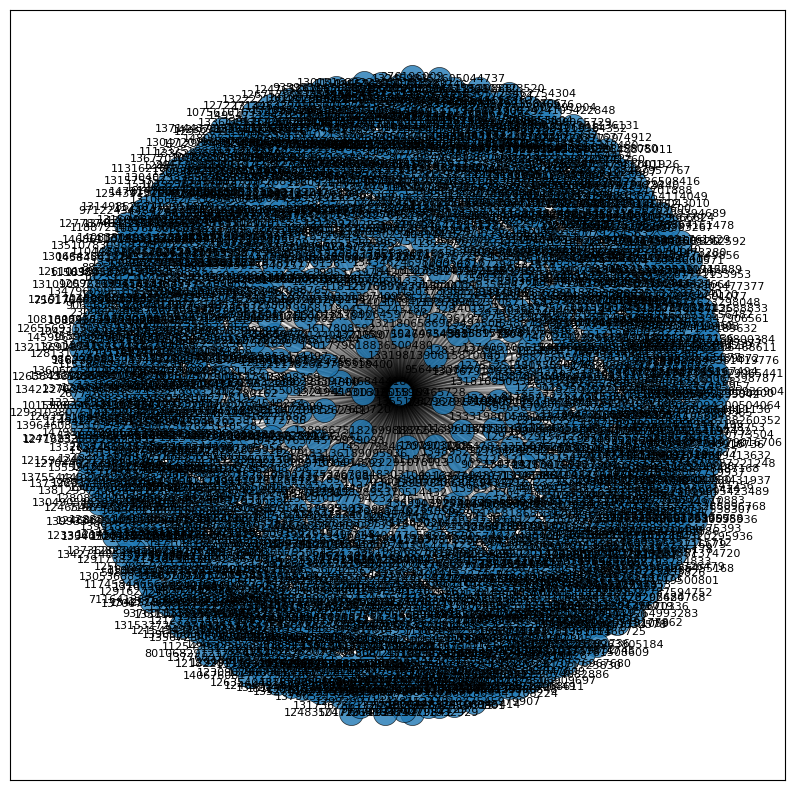

In [7]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2);

In [8]:
user_list = list(df['target']) #Use the list of followers we extracted in the code above i.e. my 450 followers
for userID in user_list:
    print(userID)
    followers = []
    follower_list = []

    # fetching the user
    user = api.get_user(screen_name='tiivik')

    # fetching the followers_count
    followers_count = user.followers_count

    try:
        for page in tweepy.Cursor(api.get_follower_ids, user_id=userID).pages():
            followers.extend(page)
            print(len(followers))
            if followers_count >= 5000: #Only take first 5000 followers
                break
    except tweepy.errors.TweepyException:
        print("error")
        continue
    follower_list.append(followers)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list[0]
    temp['source'] = userID
    df = df.append(temp)
    df.to_csv("networkOfFollowers.csv")

1460312994219364352
389
1442543278268706818


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


5000
10000
12404
1434492723235639303


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


522
1538475704647557122


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


146
1389684925075447808


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


2338
1549995510706077696


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


217
1281717374106951680


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


3
1380195834717990914


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


error
1559657479985893377
136
1554185549409394689


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


1531
1185217699753943040


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


4753
1354443150027329537


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


362
1476152509789990914


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


error
1536568522305855488
error
1112461490462826497
error
1550130835453399042
error
1300144656781639682
error
1499500703282307073
error
1557964089288163330
error
1268168890711932929
error
1388109875943780361
error
1418936805404069889
error
1554414268065398787
error
1247228353721090054
error
1349266119933177856
error
3938061
error
1407356604958318601
error
3066455977
error
1560735706741411841
error
1432281414175793156
error
1478439433099743233
error
1536694124367290368
error
1266012764109262848
error
1051217217357062145
error
1079274812005122050
error
827123387982020608
error
1559678984048488448
error
1559387841456906242
error
1310919975897620483
error
518271888
error
1386963018144260100
error
1325482937186459650
error
1556230807831937026
error
1516408630207209487
error
1539488386007719937
error
1348421087059714048
error
1334108717474852866
error
1141926157824221184
error
1514902708259540997
error
1291627246202093568
error
947895063971024897
error
1553048844845268992
error
9492497566305

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


2003
1292052556223590400


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


1027
1298351748122398727


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


2231
1332678438646390791


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


error
1333789527731695617
2938
1218246858805477377


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


1933
1324669266898128896


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


5000
5949
1218111434770399233


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


3401
1322199932946780162


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


1033
1277537670848303104


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


325


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


1325734436667875329
1691
1301516222220111875


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


820
1334231293320716289


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


3203


C:\Users\Mohsen\AppData\Local\Temp\ipykernel_8276\2877350236.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)


4880644821
error
1082237904980709376
error
1316673737534713857
error
1290282070749507584
error
1333658904459431937
error
1215200228292227072
error
1068817363695534081
error
1336187212338237440
error
1299458910177439750
error
1254391316487843840
error
1318989080001187840
error
1299971623932448768
error
1314985267409956869
error
1332322507353972737
error
1336745969304694784
error
1306643563724316672
error
1313360455524589569
error
1247129269123395588
error
1275105278397161478
error
1338560756896460801
error
1313811224044466176
error
1305581098206887936
error
1141017580418809856
error
1337842083927887877
error
1228174476300312576
error
1331981390615810048
error
1106654670246871047
error
1314117584942321664
error
1329710581868339202
error
715894120804265985
error
894705869828632577
error
1338560943060525059
error
1333715079116845056
error
1304023378517536768
error
1337831735036358659
error
1261947456335552513
error
1320403395757342720
error
1310664273329360896
error
1336240650854035456
err

In [9]:
df = pd.read_csv("networkOfFollowers.csv") #Read into a df
G = nx.from_pandas_edgelist(df, 'source', 'target')

In [10]:
G.number_of_nodes() #Find the total number of nodes in this graph

36370

In [11]:
G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['nconst','degree']
G_sorted.head()

,nconst,degree
0,1442543278268706818,12405
1,1324669266898128896,5949
2,1185217699753943040,4753
3,1218111434770399233,3402
4,1334231293320716289,3204


In [12]:
G_tmp = nx.k_core(G, 10) #Exclude nodes with degree less than 10

In [13]:
from community import community_louvain
partition = community_louvain.best_partition(G_tmp)
#Turn partition into dataframe
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

In [14]:
G_sorted = pd.DataFrame(sorted(G_tmp.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

In [15]:
combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")

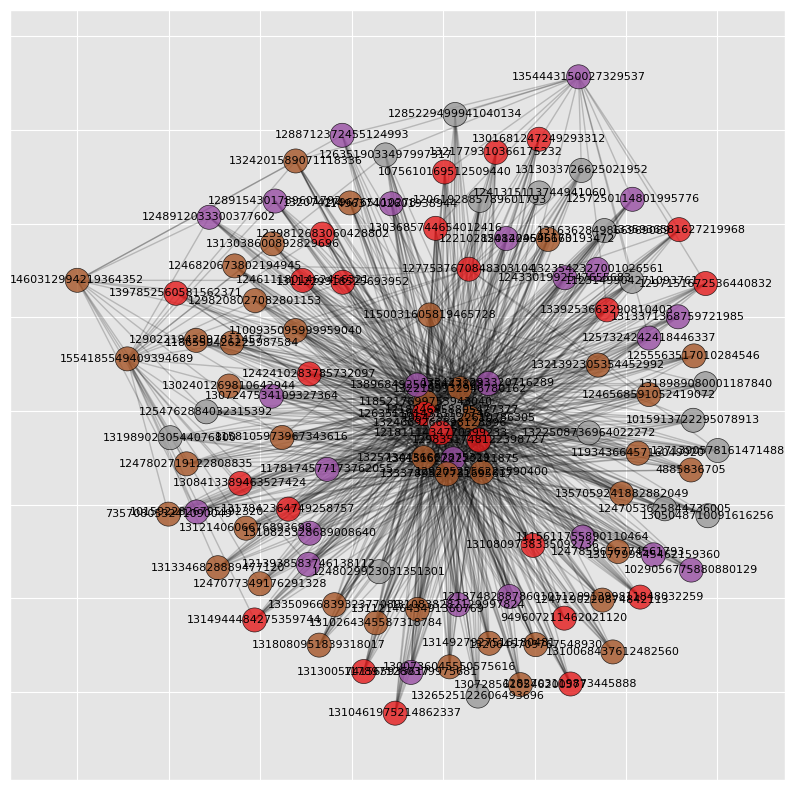

In [16]:
pos = nx.spring_layout(G_tmp)
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
#cc = nx.betweenness_centrality(G2)
nodes = nx.draw_networkx_nodes(G_tmp, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G_tmp, pos, font_size=8)
nx.draw_networkx_edges(G_tmp, pos, width=1.0, alpha=0.2)
plt.savefig('twitterFollowers.png')

In [17]:
combined = combined.rename(columns={"names": "Id"}) #I've found Gephi really likes when your node column is called 'Id'
edges = nx.to_pandas_edgelist(G_tmp)
nodes = combined['Id']
edges.to_csv("edges.csv")
combined.to_csv("nodes.csv")